# Battle of Neighborhoods - Where should construction of next Apartment complex happen in Austin, TX


This is final capstone project which aims to utilize data science concepts and machine learning tools learned in the Coursera IBM Data Science Professional Certificate Course. It intends to apply all the ideas grasped during the entire course and apply it to develop a practical project, solvinng a business problem which involved using location data.

This project aims to help Builders & Contractors with suggestions on which Neighborhoods would be optimum for the next construction that would appeal to the youth.

### Introduction

Austin is capital of Texas in United States of America and is one of the fastest growing cities. According to Austin City Government, the City of Austin has crossed the threshold of becoming a Majority-Minority city, which means that no demographic group exists as most of the City’s population. As per rankings by U.S. News and World Report, 2020, Austin is in 3rd spot for best city to live/retire. It has expanded even more in the past one year. Global pandemic has in fact accelerated its growth rather than slowing down as it was observed that more and more people and businesses have moved their base to Austin. Many people in tech industry prefer to call Austin as their home and have moved from expensive Bay Area and its enormous prices, be it in terms of houses, rents or in general a very high cost of living to relatively cheaper Austin which has a lot of offer in every aspect. 

Austin really is unique: fascinating and quirky, creative, and outdoorsy, hugely musical – and, given its setting, bizarrely anomalous. Being a fast-growing city with diverse ethnicities, Austin is a great place for entrepreneurs to start and grow their businesses. The city is also well known for its outstanding food and great live music venues.

### Business Problem

Construction in Austin is not slowing down. There are lot of big projects that are in pipeline and the opportunities are endless. With massive influx of young people in this city, there is an ever-growing demand to have more Apartment communities in great neighborhoods which have lot of amenities in and around. This project aims to help Builders & Contractors with suggestions on which Neighborhoods would be optimum for the next construction that would appeal to the youth.

In [2]:
# Importing all libraries required
import pandas as pd
import numpy as np

# To get location data
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# To create maps
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

import requests # library to handle requests

# To run Ml algorithm
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# To support visualization of data analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

Solving environment: ...working... done

# All requested packages already installed.



### 1. Downloading data from web and creating dataframe

In [3]:
# Load Austin Neighborhood data. Source: https://data.austintexas.gov/Building-and-Development/Neighborhoods/a7ap-j2yt
df = pd.read_csv("C:/Users/reshma.v.kotwani/Downloads/Neighborhoods.csv")
df.head()

the_geom  FID  TARGET_FID  \
0  MULTIPOLYGON (((-97.792307359674 30.4567073495...    3           3   
1  MULTIPOLYGON (((-97.670762852964 30.3085399639...   95          95   
2  MULTIPOLYGON (((-97.753526659646 30.2387648363...   19          19   
3  MULTIPOLYGON (((-97.738154269236 30.3027463827...   91          91   
4  MULTIPOLYGON (((-97.682624533084 30.2858668623...   49          49   

         NEIGHNAME   SqMiles     Shape_Leng   Shape__Area  Shape__Length  
0    ANDERSON MILL  8.669086  154458.205390  2.416802e+08  154458.205390  
1     WINDSOR PARK  2.383074   40527.378654  6.643628e+07   40527.378654  
2           DAWSON  0.495535   17697.924998  1.381473e+07   17697.924998  
3  WEST UNIVERSITY  0.738442   24981.044476  2.058658e+07   24981.044476  
4              MLK  1.545283   33470.415430  4.308001e+07   33470.415430

In [4]:
df.shape

(103, 8)

Adding Austin, TX, USA to neighborhood names to ensure google maps gets the correct data

In [5]:
df['NEIGHNAME'] = df['NEIGHNAME'] + ', Austin, TX, USA'

### 2. Getting location data (latitude + longitude ) for Neighborhoods in Austin

Since Geocoders was returning None as value, introduced delay between calls to get location data

In [6]:
# Code to add the latitudes and longtitudes to the dataframe
locator = Nominatim(user_agent= "myGeocoder")

# Function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

df['location'] = df['NEIGHNAME'].apply(geocode)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

In [7]:
# Drop unnecessary columns
df = df.drop(['the_geom', 'FID', 'TARGET_FID', 'SqMiles','Shape_Leng', 'Shape__Area', 'Shape__Length', 'location','point', 'altitude'], axis=1)

In [8]:
df.head()

NEIGHNAME   latitude  longitude
0    ANDERSON MILL, Austin, TX, USA  30.455835 -97.807096
1     WINDSOR PARK, Austin, TX, USA  30.313549 -97.691095
2           DAWSON, Austin, TX, USA  30.232926 -97.761418
3  WEST UNIVERSITY, Austin, TX, USA  30.285220 -97.733893
4              MLK, Austin, TX, USA  30.284035 -97.694001

Checking if there are any neighborhoods where google didn't return location data. If no latitude, longitude information is found, these rows will have to be dropped from our analysis as Folium will not be able to visualize nor Foursqaure will return any data

In [9]:
df[df.isna().any(axis=1)]

NEIGHNAME  latitude  longitude
9    WALNUT CREEK--PIONEER HILL, Austin, TX, USA       NaN        NaN
32           DITTMAR--SLAUGHTER, Austin, TX, USA       NaN        NaN
49                         RMMA, Austin, TX, USA       NaN        NaN
52                  HAYS WARTHA, Austin, TX, USA       NaN        NaN
55      VILLAGE AT WESTERN OAKS, Austin, TX, USA       NaN        NaN
57               ROBINSON RANCH, Austin, TX, USA       NaN        NaN
71            UPPER BOGGY CREEK, Austin, TX, USA       NaN        NaN
74               WHISPER VALLEY, Austin, TX, USA       NaN        NaN
76         NORTH LAMAR RUNDBERG, Austin, TX, USA       NaN        NaN
83        AVERY RANCH--LAKELINE, Austin, TX, USA       NaN        NaN
86            BARTON CREEK MALL, Austin, TX, USA       NaN        NaN
102               EAST OAK HILL, Austin, TX, USA       NaN        NaN

In [10]:
# Dropping rows with Nan values
df = df.dropna()
df.shape

(91, 3)

### 3. Explore Neighborhoods

After getting location data of neighborhoods, lets explore them on map using Folium

In [11]:
# Getting latitude and longitude for Austin
address = 'Austin, Texas'

geolocator = Nominatim(user_agent="Tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Austin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Austin are 30.2711286, -97.7436995.


In [12]:
# create map of Austin using latitude and longitude values
map_austin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['latitude'], df['longitude'], df['NEIGHNAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  
    
map_austin

#### Using Foursquare API to get nearby venues for all the neighborhoods

In [12]:
# @hidden_cell
CLIENT_ID = 'LEFO0WIZHMSERNJPXJRYQ4A2IVFH5JFGAGTKKDQCMXS0MZ0Z' 
CLIENT_SECRET = 'XKUBS5OLFMENQQ0HXDFIWXOTMEJ0JOEEELGASHRQCJV1LXC4' 
ACCESS_TOKEN = 'RRK1AMPECKDXKBUMZAUWUSLX1AU5GJOCDUXVTE5WYGGGZY5I' 
VERSION = '20180604'
LIMIT = 30

In [13]:
# Create function that gets the top 100 venues that are in the neighbourhoods within a radius of 2000 meters 
def getNearbyVenues (names, latitudes, longitudes, radius= 2000):
    
    venue_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venue_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venue_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
austin_venues = getNearbyVenues(names=df['NEIGHNAME'],
                                  latitudes=df['latitude'],
                                  longitudes=df['longitude'])

ANDERSON MILL, Austin, TX, USA
WINDSOR PARK, Austin, TX, USA
DAWSON, Austin, TX, USA
WEST UNIVERSITY, Austin, TX, USA
MLK, Austin, TX, USA
SOUTH RIVER CITY, Austin, TX, USA
MLK-183, Austin, TX, USA
OLD WEST AUSTIN, Austin, TX, USA
BOULDIN CREEK, Austin, TX, USA
SOUTHEAST, Austin, TX, USA
UNIVERSITY HILLS, Austin, TX, USA
WINDSOR ROAD, Austin, TX, USA
JESTER, Austin, TX, USA
CIRCLE C SOUTH, Austin, TX, USA
WESTGATE, Austin, TX, USA
GALINDO, Austin, TX, USA
BRODIE LANE, Austin, TX, USA
HYDE PARK, Austin, TX, USA
MCKINNEY, Austin, TX, USA
WESTOVER HILLS, Austin, TX, USA
GRACY WOODS, Austin, TX, USA
PLEASANT VALLEY, Austin, TX, USA
SOUTH LAMAR, Austin, TX, USA
PECAN SPRINGS-SPRINGDALE, Austin, TX, USA
FOUR POINTS, Austin, TX, USA
POND SPRINGS, Austin, TX, USA
ST. EDWARDS, Austin, TX, USA
UT, Austin, TX, USA
HIGHLAND, Austin, TX, USA
DOWNTOWN, Austin, TX, USA
HANCOCK, Austin, TX, USA
TECH RIDGE, Austin, TX, USA
SAMSUNG--PIONEER CROSSING, Austin, TX, USA
WEST AUSTIN NG, Austin, TX, USA
BLUFF

In [15]:
austin_venues.shape

(2532, 7)

In [16]:
austin_venues.head()

Neighborhood  Neighborhood Latitude  \
0  ANDERSON MILL, Austin, TX, USA              30.455835   
1  ANDERSON MILL, Austin, TX, USA              30.455835   
2  ANDERSON MILL, Austin, TX, USA              30.455835   
3  ANDERSON MILL, Austin, TX, USA              30.455835   
4  ANDERSON MILL, Austin, TX, USA              30.455835   

   Neighborhood Longitude                          Venue  Venue Latitude  \
0              -97.807096                   Millrun Park       30.451548   
1              -97.807096         Freda's Seafood Grille       30.464196   
2              -97.807096                        CC Zing       30.460979   
3              -97.807096              Thundercloud Subs       30.461629   
4              -97.807096  Almarah Mediterranean Cuisine       30.461054   

   Venue Longitude            Venue Category  
0       -97.802975                      Park  
1       -97.803776        Seafood Restaurant  
2       -97.816818             Smoothie Shop  
3       -97.795651            Sandwich Place  
4       -97.817103  Mediterranean Restaurant

In [17]:
# Group venues by Neighborhood
austin_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                                    
ALLANDALE, Austin, TX, USA                         30                      30   
ANDERSON MILL, Austin, TX, USA                     30                      30   
BARTON HILLS, Austin, TX, USA                      30                      30   
BERGSTROM, Austin, TX, USA                         30                      30   
BLUFF SPRINGS, Austin, TX, USA                     30                      30   
...                                               ...                     ...   
WINDSOR HILLS, Austin, TX, USA                     30                      30   
WINDSOR PARK, Austin, TX, USA                      30                      30   
WINDSOR ROAD, Austin, TX, USA                      30                      30   
WOOTEN, Austin, TX, USA                            30                      30   
ZILKER, Austin, TX, USA                            30                      30   

                                Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                             
ALLANDALE, Austin, TX, USA         30              30               30   
ANDERSON MILL, Austin, TX, USA     30              30               30   
BARTON HILLS, Austin, TX, USA      30              30               30   
BERGSTROM, Austin, TX, USA         30              30               30   
BLUFF SPRINGS, Austin, TX, USA     30              30               30   
...                               ...             ...              ...   
WINDSOR HILLS, Austin, TX, USA     30              30               30   
WINDSOR PARK, Austin, TX, USA      30              30               30   
WINDSOR ROAD, Austin, TX, USA      30              30               30   
WOOTEN, Austin, TX, USA            30              30               30   
ZILKER, Austin, TX, USA            30              30               30   

                                Venue Category  
Neighborhood                                    
ALLANDALE, Austin, TX, USA                  30  
ANDERSON MILL, Austin, TX, USA              30  
BARTON HILLS, Austin, TX, USA               30  
BERGSTROM, Austin, TX, USA                  30  
BLUFF SPRINGS, Austin, TX, USA              30  
...                                        ...  
WINDSOR HILLS, Austin, TX, USA              30  
WINDSOR PARK, Austin, TX, USA               30  
WINDSOR ROAD, Austin, TX, USA               30  
WOOTEN, Austin, TX, USA                     30  
ZILKER, Austin, TX, USA                     30  

[91 rows x 6 columns]

In [18]:
print('There are {} unique categories of venues.'.format(len(austin_venues['Venue Category'].unique())))

There are 268 unique categories of venues.


In [19]:
# To analyze all the individual venue categories returned by Foursquare API
pd.set_option("display.max_rows", None, "display.max_columns", None)

print(austin_venues['Venue Category'].value_counts())

Mexican Restaurant                          133
Coffee Shop                                 124
Park                                         71
Pizza Place                                  69
Taco Place                                   62
Food Truck                                   62
Sandwich Place                               58
Burger Joint                                 56
Hotel                                        47
Ice Cream Shop                               47
American Restaurant                          44
Brewery                                      43
Fast Food Restaurant                         43
BBQ Joint                                    41
Convenience Store                            40
Vietnamese Restaurant                        40
Grocery Store                                40
Bar                                          38
Café                                         34
Gym / Fitness Center                         34
Gym                                     

In [20]:
austin_venues = austin_venues.drop(['Venue Latitude', 'Venue Longitude'], axis=1)

As it can be seen, there were too many venue categories and many of the venue categories fell under same category. Asian Restaurant, Mexican Restaurant can be grouped under common category. Likewise there are similar names like Gym, Fitness they can be merged to form one common category.

After observing, all Venue Categories will be clubbed under 4 main categories as listed below
1.	Food & drinks - which includes all different types of restaurants like Mexican, American etc. along with Pizza, Burger places. All desserts, beverages (alcoholic + non-alcoholic) were clubbed under this category. This category had the maximum counts.
2.	Recreation - category included venues like Parks, Spas, Golf courses, Arcade, etc.
3.	Shopping - category included Supermarkets, malls, grocery stores, convenience stores, pharmacy, etc.
4.	Gym - was the final category that was determined after observing the data.


In [21]:
# Splitting the data and forming groups of similar venue categories
gym = austin_venues[austin_venues['Venue Category'].str.contains('Gym')]

food = '|'.join(['Restaurant','Sandwich','Pizza','Burger','Taco','Diner','Steak','Burrito','Joint','Food','Coffee','Café','Bar','Brewery','Bakery','Liquor','Dessert','Cream','Breakfast'])
food_drinks = austin_venues[austin_venues['Venue Category'].str.contains(food)]

recreation = austin_venues[austin_venues['Venue Category'].str.contains('Park' or 'Golf' or 'Spa' or 'Arcade' or 'Play' or 'Sports' or 'Game' or 'Yoga' or 'Pool')]
shopping = austin_venues[austin_venues['Venue Category'].str.contains('Grocery' or 'Convenience' or 'Pharmacy' or 'Discount' or 'Supermarket' or 'Shopping' or 'Cosmetics' or 'Market')]

In [22]:
# Replace the variations with common Category name
food_drinks.loc[:,'Venue Category'] = str('Food Drinks')
gym.loc[:,'Venue Category'] = str('Gym')
recreation.loc[:,'Venue Category'] = str('Recreation')
shopping.loc[:,'Venue Category'] = str('Shopping')

C:\Users\reshma.v.kotwani\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [23]:
# Combining the groups together
frames = [gym, food_drinks, recreation, shopping]
df_final = pd.concat(frames, keys=['Gym', 'Food Drinks', 'Recreation', 'Shopping'])

In [24]:
df_final.shape

(1619, 5)

In [25]:
# This is the final data of corrected Venue Categories
df_final

Neighborhood  \
Gym         8                 ANDERSON MILL, Austin, TX, USA   
            81                       DAWSON, Austin, TX, USA   
            183                     MLK-183, Austin, TX, USA   
            269                   SOUTHEAST, Austin, TX, USA   
            283                   SOUTHEAST, Austin, TX, USA   
            357                      JESTER, Austin, TX, USA   
            418                    WESTGATE, Austin, TX, USA   
            441                     GALINDO, Austin, TX, USA   
            451                     GALINDO, Austin, TX, USA   
            464                 BRODIE LANE, Austin, TX, USA   
            482                   HYDE PARK, Austin, TX, USA   
            559              WESTOVER HILLS, Austin, TX, USA   
            567                 GRACY WOODS, Austin, TX, USA   
            589                 GRACY WOODS, Austin, TX, USA   
            619             PLEASANT VALLEY, Austin, TX, USA   
            646                 SOUTH LAMAR, Austin, TX, USA   
            656    PECAN SPRINGS-SPRINGDALE, Austin, TX, USA   
            694                 FOUR POINTS, Austin, TX, USA   
            697                 FOUR POINTS, Austin, TX, USA   
            821                    HIGHLAND, Austin, TX, USA   
            860                    DOWNTOWN, Austin, TX, USA   
            895                  TECH RIDGE, Austin, TX, USA   
            928   SAMSUNG--PIONEER CROSSING, Austin, TX, USA   
            935              WEST AUSTIN NG, Austin, TX, USA   
            961              WEST AUSTIN NG, Austin, TX, USA   
            964               BLUFF SPRINGS, Austin, TX, USA   
            971               BLUFF SPRINGS, Austin, TX, USA   
            1003                 MONTOPOLIS, Austin, TX, USA   
            1035               CHERRY CREEK, Austin, TX, USA   
            1051               CHERRY CREEK, Austin, TX, USA   
            1081               BARTON HILLS, Austin, TX, USA   
            1083                    GATEWAY, Austin, TX, USA   
            1098                    GATEWAY, Austin, TX, USA   
            1132                     WOOTEN, Austin, TX, USA   
            1136                     WOOTEN, Austin, TX, USA   
            1195              GARRISON PARK, Austin, TX, USA   
            1216             GEORGIAN ACRES, Austin, TX, USA   
            1218             GEORGIAN ACRES, Austin, TX, USA   
            1238             GEORGIAN ACRES, Austin, TX, USA   
            1303                 NORTH LOOP, Austin, TX, USA   
            1309                     MCNEIL, Austin, TX, USA   
            1316                     MCNEIL, Austin, TX, USA   
            1320                     MCNEIL, Austin, TX, USA   
            1324                     MCNEIL, Austin, TX, USA   
            1359      DAVENPORT LAKE AUSTIN, Austin, TX, USA   
            1376                     ZILKER, Austin, TX, USA   
            1389                     ZILKER, Austin, TX, USA   
            1441              WEST CONGRESS, Austin, TX, USA   
            1493             HERITAGE HILLS, Austin, TX, USA   
            1494             HERITAGE HILLS, Austin, TX, USA   
            1646               NORTH BURNET, Austin, TX, USA   
            1701               SOUTH BRODIE, Austin, TX, USA   
            1720                    GOVALLE, Austin, TX, USA   
            1749          NORTH SHOAL CREEK, Austin, TX, USA   
            1802                  RIVERSIDE, Austin, TX, USA   
            1815              WEST OAK HILL, Austin, TX, USA   
            1829              WEST OAK HILL, Austin, TX, USA   
            1898              HIGHLAND PARK, Austin, TX, USA   
            1935                   ROSEWOOD, Austin, TX, USA   
            1965                PARKER LANE, Austin, TX, USA   
            1997                  ALLANDALE, Austin, TX, USA   
            2020              EAST CONGRESS, Austin, TX, USA   
            2117

In [26]:
# Counts are checked to see which venue category has what counts
df_final['Venue Category'].value_counts()

Food Drinks    1429
Recreation       75
Gym              73
Shopping         42
Name: Venue Category, dtype: int64

Maximum count of venue returned by Foursquare API are around food, drinks

In [27]:
# create map of venues in Austin using latitude and longitude values
map_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_final['Neighborhood Latitude'], df_final['Neighborhood Longitude'], df_final['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)  
    
map_venues

### One hot encoding technique is used to convert categorical Venue Categories into numbers for Machine Learning algorithm 

In [28]:
# one hot encoding
austin_onehot = pd.get_dummies(df_final[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
austin_onehot['Neighborhood'] = df_final['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
austin_onehot = austin_onehot[fixed_columns]

austin_onehot.head()

Neighborhood  Food Drinks  Gym  Recreation  \
Gym 8    ANDERSON MILL, Austin, TX, USA            0    1           0   
    81          DAWSON, Austin, TX, USA            0    1           0   
    183        MLK-183, Austin, TX, USA            0    1           0   
    269      SOUTHEAST, Austin, TX, USA            0    1           0   
    283      SOUTHEAST, Austin, TX, USA            0    1           0   

         Shopping  
Gym 8           0  
    81          0  
    183         0  
    269         0  
    283         0

In [29]:
# Checking the individual count of each Venue category across Neighborhoods and grouping the data to get a single row of 
# neighborhoods and all venues in that neighborhood combined
austin_grouped = austin_onehot.groupby('Neighborhood', as_index=False).agg({'Food Drinks': 'sum', 'Gym': 'sum', 'Recreation': 'sum', 'Shopping': 'sum'})
austin_grouped.head()

Neighborhood  Food Drinks  Gym  Recreation  Shopping
0      ALLANDALE, Austin, TX, USA           22    1           1         0
1  ANDERSON MILL, Austin, TX, USA           14    1           2         1
2   BARTON HILLS, Austin, TX, USA           18    1           0         0
3      BERGSTROM, Austin, TX, USA           13    0           0         0
4  BLUFF SPRINGS, Austin, TX, USA           16    2           0         1

Adding location information of neighborhoods to the venue data

In [30]:
# Merge austin_grouped with df to add latitude/longitude for each neighborhood
aus_merged = df.rename(columns={"NEIGHNAME": "Neighborhood"})
aus_merged = aus_merged.join(austin_grouped.set_index('Neighborhood'), on='Neighborhood')

aus_merged.head()

Neighborhood   latitude  longitude  Food Drinks  Gym  \
0    ANDERSON MILL, Austin, TX, USA  30.455835 -97.807096           14    1   
1     WINDSOR PARK, Austin, TX, USA  30.313549 -97.691095           20    0   
2           DAWSON, Austin, TX, USA  30.232926 -97.761418           22    1   
3  WEST UNIVERSITY, Austin, TX, USA  30.285220 -97.733893           12    0   
4              MLK, Austin, TX, USA  30.284035 -97.694001           18    0   

   Recreation  Shopping  
0           2         1  
1           1         1  
2           0         0  
3           0         0  
4           3         1

In [32]:
# Preparing cluster to run K means clustering algorithm
aus_cluster = aus_merged.drop(['Neighborhood'],1)
aus_cluster

latitude  longitude  Food Drinks  Gym  Recreation  Shopping
0    30.455835 -97.807096           14    1           2         1
1    30.313549 -97.691095           20    0           1         1
2    30.232926 -97.761418           22    1           0         0
3    30.285220 -97.733893           12    0           0         0
4    30.284035 -97.694001           18    0           3         1
5    30.249443 -97.745558           16    0           1         0
6    30.279398 -97.673922            8    1           2         0
7    30.296822 -97.754851           20    0           2         1
8    30.255667 -97.755481           21    0           2         0
10   30.347189 -97.714563           16    2           0         1
11   30.317580 -97.673917           16    0           2         1
12   30.297217 -97.768858            8    0           5         0
13   30.387517 -97.799267            5    1           0         1
14   30.249757 -97.748323           16    0           1         0
15   30.227962 -97.800881           16    1           0         1
16   30.235578 -97.768515           21    2           0         0
17   30.144467 -97.852284           10    1           0         0
18   30.304412 -97.730448           16    1           2         1
19   30.205876 -97.728015           18    0           1         0
20   30.379933 -97.749599           13    1           1         2
21   30.402186 -97.700421           16    2           1         1
22   30.230263 -97.724199           23    1           0         0
23   30.236389 -97.782647           14    1           0         1
24   30.297212 -97.675498            6    1           2         2
25   30.403834 -97.853879           17    2           0         1
26   30.450620 -97.785310           22    0           0         0
27   30.226948 -97.754610           18    0           1         0
28   30.279308 -97.742845           11    0           1         0
29   30.328895 -97.715847           21    1           0         1
30   30.268054 -97.744764           17    1           1         1
31   30.295896 -97.724768           19    0           0         2
33   30.407091 -97.666131           15    1           1         2
34   30.360492 -97.640850            2    1           0         0
35   30.265587 -97.746996           17    2           1         0
36   30.178720 -97.775929           16    2           0         1
37   30.224946 -97.703444           11    1           1         0
38   30.197113 -97.824812           16    2           1         1
39   30.251571 -97.784106           18    1           0         0
40   30.395185 -97.739643           14    2           0         2
41   30.361252 -97.722846           18    2           0         0
42   30.255951 -97.717052           25    0           0         0
43   30.206373 -97.799747           21    1           1         1
44   30.391267 -97.906984            1    0           3         0
45   30.350096 -97.701756           16    3           0         0
46   30.255896 -97.731707           19    0           0         0
47   30.317882 -97.718758           22    1           0         0
48   30.442015 -97.743840           16    4           1         2
50   30.324188 -97.810834           12    1           0         0
51   30.254236 -97.769581           17    2           0         0
53   30.312011 -97.655739            9    0           1         1
54   30.215382 -97.772770           20    1           1         0
56   30.211404 -97.652544           16    0           0         0
58   30.404300 -97.792960            0    0           1         0
59   30.345796 -97.690991           11    2           2         1
60   30.284864 -97.759106           18    0           3         1
61   30.279257 -97.713717           23    0           0         0
62   30.313390 -97.744898           21    0           1         0
63   30.174432 -97.621398            2    0           3         0
64   30.380581 -97.723556           17    1           0         1
65   30.193489 -97.665010           13    0   

### 4. Using K-means for clustering neighborhoods

Before running K-means algorithm to form clusters of neighborhoods, it is important to determine what is the best K value. Elbow method will be used to determine which is best K for running clustering ML unsupervised algorithm

1 : 4.911058727951998
2 : 3.333963685653499
3 : 2.320298071345757
4 : 1.8884282345791334
5 : 1.723228538489212
6 : 1.5365170003951667
7 : 1.448185617241461
8 : 1.360481400121136
9 : 1.2940434713190598


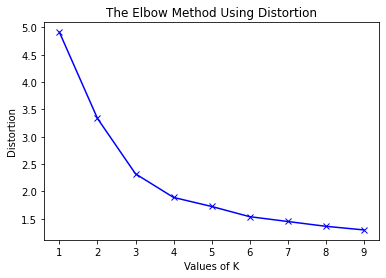

In [33]:
# Elbow method using Distortion
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(aus_cluster) 
    kmeanModel.fit(aus_cluster)     
      
    distortions.append(sum(np.min(cdist(aus_cluster, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / aus_cluster.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(aus_cluster, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / aus_cluster.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method Using Distortion') 
plt.show()

1 : 3412.016700649857
2 : 1232.310811713702
3 : 587.1758450812503
4 : 391.6858770334796
5 : 312.96922429713095
6 : 246.88363379750567
7 : 219.8865923246987
8 : 193.9662614675583
9 : 176.45203000822028


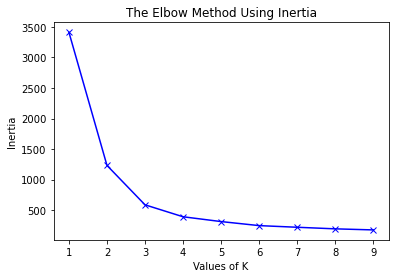

In [35]:
# Elbow method using Inertia
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method Using Inertia') 
plt.show()

K value is observed at elbow points to check at what point is distortion/inertia decreasing in linear fashion. Value of K as 4 is considered as optimal to run clustering algorithm from the observations of different elbow methods above.

In [36]:
# Running K means algorithm
k=4
kmeans = KMeans(n_clusters = k,random_state=0).fit(aus_cluster)
kmeans.labels_
aus_merged.insert(0, 'Clusters', kmeans.labels_)

In [37]:
aus_merged

Clusters                                Neighborhood   latitude  \
0           3              ANDERSON MILL, Austin, TX, USA  30.455835   
1           2               WINDSOR PARK, Austin, TX, USA  30.313549   
2           2                     DAWSON, Austin, TX, USA  30.232926   
3           3            WEST UNIVERSITY, Austin, TX, USA  30.285220   
4           0                        MLK, Austin, TX, USA  30.284035   
5           0           SOUTH RIVER CITY, Austin, TX, USA  30.249443   
6           3                    MLK-183, Austin, TX, USA  30.279398   
7           2            OLD WEST AUSTIN, Austin, TX, USA  30.296822   
8           2              BOULDIN CREEK, Austin, TX, USA  30.255667   
10          0                  SOUTHEAST, Austin, TX, USA  30.347189   
11          0           UNIVERSITY HILLS, Austin, TX, USA  30.317580   
12          3               WINDSOR ROAD, Austin, TX, USA  30.297217   
13          1                     JESTER, Austin, TX, USA  30.387517   
14          0             CIRCLE C SOUTH, Austin, TX, USA  30.249757   
15          0                   WESTGATE, Austin, TX, USA  30.227962   
16          2                    GALINDO, Austin, TX, USA  30.235578   
17          3                BRODIE LANE, Austin, TX, USA  30.144467   
18          0                  HYDE PARK, Austin, TX, USA  30.304412   
19          0                   MCKINNEY, Austin, TX, USA  30.205876   
20          3             WESTOVER HILLS, Austin, TX, USA  30.379933   
21          0                GRACY WOODS, Austin, TX, USA  30.402186   
22          2            PLEASANT VALLEY, Austin, TX, USA  30.230263   
23          3                SOUTH LAMAR, Austin, TX, USA  30.236389   
24          1   PECAN SPRINGS-SPRINGDALE, Austin, TX, USA  30.297212   
25          0                FOUR POINTS, Austin, TX, USA  30.403834   
26          2               POND SPRINGS, Austin, TX, USA  30.450620   
27          0                ST. EDWARDS, Austin, TX, USA  30.226948   
28          3                         UT, Austin, TX, USA  30.279308   
29          2                   HIGHLAND, Austin, TX, USA  30.328895   
30          0                   DOWNTOWN, Austin, TX, USA  30.268054   
31          0                    HANCOCK, Austin, TX, USA  30.295896   
33          0                 TECH RIDGE, Austin, TX, USA  30.407091   
34          1  SAMSUNG--PIONEER CROSSING, Austin, TX, USA  30.360492   
35          0             WEST AUSTIN NG, Austin, TX, USA  30.265587   
36          0              BLUFF SPRINGS, Austin, TX, USA  30.178720   
37          3                 MONTOPOLIS, Austin, TX, USA  30.224946   
38          0               CHERRY CREEK, Austin, TX, USA  30.197113   
39          0               BARTON HILLS, Austin, TX, USA  30.251571   
40          3                    GATEWAY, Austin, TX, USA  30.395185   
41          0                     WOOTEN, Austin, TX, USA  30.361252   
42          2                      HOLLY, Austin, TX, USA  30.255951   
43          2              GARRISON PARK, Austin, TX, USA  30.206373   
44          1     MANSFIELD--RIVER PLACE, Austin, TX, USA  30.391267   
45          0             GEORGIAN ACRES, Austin, TX, USA  30.350096   
46          0          EAST CESAR CHAVEZ, Austin, TX, USA  30.255896   
47          2                 NORTH LOOP, Austin, TX, USA  30.317882   
48          0                     MCNEIL, Austin, TX, USA  30.442015   
50          3      DAVENPORT LAKE AUSTIN, Austin, TX, USA  30.324188   
51          0                     ZILKER, Austin, TX, USA  30.254236   
53          3                        LBJ, Austin, TX, USA  30.312011   
54          2              WEST CONGRESS, Austin, TX, USA  30.215382   
56          0                  DEL VALLE, Austin, TX, USA  30.211404   
58          1                 BULL CREEK, Austin, TX, USA  30.404300   
59          3             HERITAGE HILLS, Austin, TX, USA  30.345796   
60          0                OLD ENFIELD, Aus

In [38]:
aus_merged.shape

(91, 8)

Map is being plotted using Folium to observe the clusters generated

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(aus_merged['latitude'], aus_merged['longitude'], aus_merged['Neighborhood'], aus_merged['Clusters']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
# Data is grouped by Clusters to get individual count of different Venue Category across each cluster
aus_count = aus_merged.drop(['Neighborhood','latitude','longitude'],1) 
aus_count = aus_count.groupby(['Clusters'], as_index=False).agg({'Food Drinks': np.sum, 'Gym': np.sum,'Recreation': np.sum, 'Shopping': np.sum})

aus_count = aus_count.set_index('Clusters')
aus_count

Food Drinks  Gym  Recreation  Shopping
Clusters                                        
0               611.0   36          29        24
1                26.0    3          13         4
2               566.0   17          14         5
3               226.0   17          19         9

### 5. Data Visualization

(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

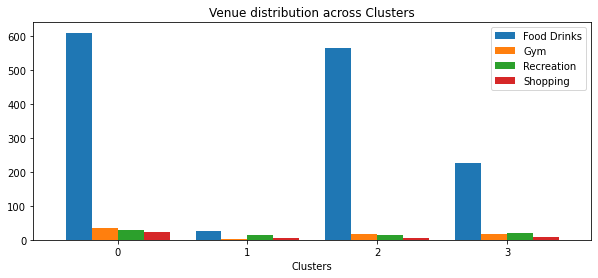

In [41]:
# Plotting bar graph to show the distribution of venues across Clusters
aus_count.plot(kind="bar",figsize=(10,4),width = 0.8)
plt.title("Venue distribution across Clusters")
plt.xticks(rotation=0)

#####  As can be observed from above, Cluster 0 had the maximum count of Venues considering all 4 categories in comparison to remaining 3 clusters. 

### 6. Get demographic information for Austin 

In [42]:
# Source: https://www.austintexas.gov/page/demographic-data (Table II)
import xlrd
demo = pd.read_excel('C:/Users/reshma.v.kotwani/Downloads/Neighborhood_Reporting_Areas_Table_II.xlsx',
                   sheet_name = "Table",
                   skiprows = range(1, 17),
                   usecols = "B:C,P:AC")

In [43]:
demo.head()

Unnamed: 1  Unnamed: 2  Unnamed: 15  Unnamed: 16  Unnamed: 17  \
0              ALLENDALE        6643     0.063224     0.054945     0.043504   
1          ANDERSON MILL       28473     0.062410     0.073192     0.077020   
2  AVERY RANCH--LAKELINE       14785     0.111532     0.090971     0.066824   
3      BARTON CREEK MALL        5147     0.052263     0.070915     0.083932   
4           BARTON HILLS        8022     0.030666     0.034156     0.029294   

   Unnamed: 18  Unnamed: 19  Unnamed: 20  Unnamed: 21  Unnamed: 22  \
0     0.024086     0.010537     0.042451     0.156104     0.171609   
1     0.047940     0.022056     0.046500     0.116637     0.157693   
2     0.030977     0.011701     0.045384     0.202164     0.216638   
3     0.056926     0.019623     0.044492     0.101418     0.137167   
4     0.018325     0.010222     0.107205     0.291573     0.147469   

   Unnamed: 23  Unnamed: 24  Unnamed: 25  Unnamed: 26  Unnamed: 27  \
0     0.149631     0.075267     0.056601     0.067891     0.054493   
1     0.176799     0.064658     0.055175     0.060935     0.028132   
2     0.120528     0.038147     0.026581     0.026987     0.008928   
3     0.171751     0.080435     0.059452     0.047601     0.035749   
4     0.114934     0.062329     0.048990     0.048118     0.031788   

   Unnamed: 28  
0     0.029655  
1     0.010852  
2     0.002638  
3     0.038275  
4     0.024931

In [44]:
# Setting column names for data
demo = demo.rename(columns={"Unnamed: 1": "Neighborhood", "Unnamed: 2": "Total Population", "Unnamed: 15": "Age 0-4", "Unnamed: 16": "Age 5-9", "Unnamed: 17": "Age 10-14", "Unnamed: 18": "Age 15-17", "Unnamed: 19": "Age 18-19", "Unnamed: 20": "Age 20-24","Unnamed: 21": "Age 25-34", "Unnamed: 22": "Age 35-44", "Unnamed: 23": "Age 45-54", "Unnamed: 24": "Age 55-59", "Unnamed: 25": "Age 60-64", "Unnamed: 26": "Age 65-74", "Unnamed: 27": "Age 75-84", "Unnamed: 28": "Age 85 Plus"})

In [45]:
demo.head()

Neighborhood  Total Population   Age 0-4   Age 5-9  Age 10-14  \
0              ALLENDALE              6643  0.063224  0.054945   0.043504   
1          ANDERSON MILL             28473  0.062410  0.073192   0.077020   
2  AVERY RANCH--LAKELINE             14785  0.111532  0.090971   0.066824   
3      BARTON CREEK MALL              5147  0.052263  0.070915   0.083932   
4           BARTON HILLS              8022  0.030666  0.034156   0.029294   

   Age 15-17  Age 18-19  Age 20-24  Age 25-34  Age 35-44  Age 45-54  \
0   0.024086   0.010537   0.042451   0.156104   0.171609   0.149631   
1   0.047940   0.022056   0.046500   0.116637   0.157693   0.176799   
2   0.030977   0.011701   0.045384   0.202164   0.216638   0.120528   
3   0.056926   0.019623   0.044492   0.101418   0.137167   0.171751   
4   0.018325   0.010222   0.107205   0.291573   0.147469   0.114934   

   Age 55-59  Age 60-64  Age 65-74  Age 75-84  Age 85 Plus  
0   0.075267   0.056601   0.067891   0.054493     0.029655  
1   0.064658   0.055175   0.060935   0.028132     0.010852  
2   0.038147   0.026581   0.026987   0.008928     0.002638  
3   0.080435   0.059452   0.047601   0.035749     0.038275  
4   0.062329   0.048990   0.048118   0.031788     0.024931

In [46]:
demo.shape

(103, 16)

As it can be observed, several columns can be clubbed together to form age groups and reduce the number of columns. 

In [47]:
# Forming groups to combine columns
df_less18 = demo['Age 0-4'] + demo['Age 5-9'] + demo['Age 10-14'] + demo['Age 15-17']
df_18to24 = demo['Age 18-19'] + demo['Age 20-24']
df_55to64 = demo['Age 55-59'] + demo['Age 60-64']
demo['Age 65 Plus'] = demo['Age 65-74'] + demo['Age 75-84'] + demo['Age 85 Plus']

# drop the individual columns
demo = demo.drop(['Age 0-4','Age 5-9','Age 10-14','Age 15-17', 'Age 18-19', 'Age 20-24', 'Age 55-59', 'Age 60-64', 'Age 65-74', 'Age 75-84', 'Age 85 Plus'],1)

# Add the grouped columns back in df
demo.insert(2, 'Age < 18', df_less18)
demo.insert(3, 'Age 18-24', df_18to24)
demo.insert(7, 'Age 55-64', df_55to64)

In [48]:
# Final demographic data
demo.head()

Neighborhood  Total Population  Age < 18  Age 18-24  Age 25-34  \
0              ALLENDALE              6643  0.185759   0.052988   0.156104   
1          ANDERSON MILL             28473  0.260563   0.068556   0.116637   
2  AVERY RANCH--LAKELINE             14785  0.300304   0.057085   0.202164   
3      BARTON CREEK MALL              5147  0.264037   0.064115   0.101418   
4           BARTON HILLS              8022  0.112441   0.117427   0.291573   

   Age 35-44  Age 45-54  Age 55-64  Age 65 Plus  
0   0.171609   0.149631   0.131868     0.152040  
1   0.157693   0.176799   0.119833     0.099919  
2   0.216638   0.120528   0.064728     0.038553  
3   0.137167   0.171751   0.139887     0.121624  
4   0.147469   0.114934   0.111319     0.104837

In [49]:
# Adding Austin, TX, USA to neighborhood data of demographic so that it can be grouped with our Neighborhood data
demo['Neighborhood'] = demo['Neighborhood'] + ', Austin, TX, USA'

In [50]:
# Find where neighborhoods dont match
demo[~demo['Neighborhood'].isin(df['NEIGHNAME'])]

Neighborhood  Total Population  Age < 18  \
0                    ALLENDALE, Austin, TX, USA              6643  0.185759   
2        AVERY RANCH--LAKELINE, Austin, TX, USA             14785  0.300304   
3            BARTON CREEK MALL, Austin, TX, USA              5147  0.264037   
7                      BOULDIN, Austin, TX, USA              5510  0.202722   
12         CENTRAL WEST AUSTIN, Austin, TX, USA             10522  0.231800   
18      DAVENPORT--LAKE AUSTIN, Austin, TX, USA              5161  0.284829   
23          DITTMAR--SLAUGHTER, Austin, TX, USA             15697  0.224247   
27               EAST OAK HILL, Austin, TX, USA             14508  0.195754   
33               GEORGIA ACRES, Austin, TX, USA              8559  0.292207   
38                 HAYS WARTHA, Austin, TX, USA                 2  0.000000   
50                      MCNIEL, Austin, TX, USA             23322  0.165552   
54                     MUELLER, Austin, TX, USA              2070  0.205314   
55                        NACA, Austin, TX, USA             28604  0.301077   
66    PECAN SPRINGS--SPINGDALE, Austin, TX, USA              4832  0.258899   
70              ROBINSON RANCH, Austin, TX, USA               873  0.122566   
83                    ST. JOHN, Austin, TX, USA              9348  0.293860   
84                 SWEET BRIAR, Austin, TX, USA              5746  0.190045   
86              TRIANGLE-STATE, Austin, TX, USA              1707  0.043351   
88           UPPER BOGGY CREEK, Austin, TX, USA              5302  0.131460   
90     VILLAGE AT WESTERN OAKS, Austin, TX, USA             10163  0.275804   
91  WALNUT CREEK--PIONEER HILL, Austin, TX, USA              3012  0.209495   
97              WHISPER VALLEY, Austin, TX, USA                 6  0.333333   

    Age 18-24  Age 25-34  Age 35-44  Age 45-54  Age 55-64  Age 65 Plus  
0    0.052988   0.156104   0.171609   0.149631   0.131868     0.152040  
2    0.057085   0.202164   0.216638   0.120528   0.064728     0.038553  
3    0.064115   0.101418   0.137167   0.171751   0.139887     0.121624  
7    0.106715   0.264247   0.172595   0.115426   0.080036     0.058258  
12   0.060065   0.186657   0.152823   0.140848   0.119369     0.108439  
18   0.044565   0.079442   0.161209   0.178648   0.156753     0.094555  
23   0.102758   0.206982   0.156208   0.141365   0.105434     0.063006  
27   0.087331   0.231114   0.147091   0.136821   0.112559     0.089330  
33   0.140671   0.208669   0.145578   0.109709   0.064026     0.039140  
38   0.000000   0.000000   0.000000   1.000000   0.000000     0.000000  
50   0.098962   0.265029   0.155261   0.135623   0.106166     0.073407  
54   0.119324   0.309662   0.194203   0.088889   0.058937     0.023671  
55   0.126381   0.213047   0.145085   0.101384   0.062579     0.050447  
66   0.098303   0.170116   0.135141   0.117343   0.100786     0.119412  
70   0.115693   0.329897   0.174112   0.093929   0.103093     0.060710  
83   0.159820   0.230210   0.129867   0.093389   0.051134     0.041720  
84   0.205534   0.247825   0.123390   0.095719   0.079011     0.058475  
86   0.483304   0.264206   0.069127   0.062097   0.052724     0.025190  
88   0.132591   0.312524   0.158054   0.103169   0.087514     0.074689  
90   0.044967   0.146217   0.195415   0.161468   0.104300     0.071829  
91   0.130146   0.278884   0.146746   0.113214   0.071049     0.050465  
97   0.000000   0.000000   0.000000   0.166667   0.500000     0.000000

As it can be observed, there are typos in neighborhoods name like Allendale/ Allandale, Davenport--Lake/ Daveport Lake which will not be merged in join. All the data variations in neighborhood names have to be corrected

In [51]:
# Correct the anomalies
demo['Neighborhood'] = demo['Neighborhood'].replace(['ALLENDALE, Austin, TX, USA'], 'ALLANDALE, Austin, TX, USA')
demo['Neighborhood'] = demo['Neighborhood'].replace(['BOULDIN, Austin, TX, USA'], 'BOULDIN CREEK, Austin, TX, USA')
demo['Neighborhood'] = demo['Neighborhood'].replace(['DAVENPORT--LAKE AUSTIN, Austin, TX, USA'], 'DAVENPORT LAKE AUSTIN, Austin, TX, USA')
demo['Neighborhood'] = demo['Neighborhood'].replace(['GEORGIA ACRES, Austin, TX, USA'], 'GEORGIAN ACRES, Austin, TX, USA')
demo['Neighborhood'] = demo['Neighborhood'].replace(['MCNIEL, Austin, TX, USA'], 'MCNEIL, Austin, TX, USA')
demo['Neighborhood'] = demo['Neighborhood'].replace(['PECAN SPRINGS--SPINGDALE, Austin, TX, USA'], 'PECAN SPRINGS-SPRINGDALE, Austin, TX, USA')
demo['Neighborhood'] = demo['Neighborhood'].replace(['ST. JOHN, Austin, TX, USA'], 'ST. JOHNS, Austin, TX, USA')
demo['Neighborhood'] = demo['Neighborhood'].replace(['SWEET BRIAR, Austin, TX, USA'], 'SWEETBRIAR, Austin, TX, USA')
demo['Neighborhood'] = demo['Neighborhood'].replace(['TRIANGLE-STATE, Austin, TX, USA'], 'TRIANGLE STATE, Austin, TX, USA')

In [52]:
# Merge demographic information with Cluster analysis information
df_austin = pd.merge(aus_merged, demo, how = "left", on=["Neighborhood"])

In [53]:
df_austin

Clusters                                Neighborhood   latitude  \
0          3              ANDERSON MILL, Austin, TX, USA  30.455835   
1          2               WINDSOR PARK, Austin, TX, USA  30.313549   
2          2                     DAWSON, Austin, TX, USA  30.232926   
3          3            WEST UNIVERSITY, Austin, TX, USA  30.285220   
4          0                        MLK, Austin, TX, USA  30.284035   
5          0           SOUTH RIVER CITY, Austin, TX, USA  30.249443   
6          3                    MLK-183, Austin, TX, USA  30.279398   
7          2            OLD WEST AUSTIN, Austin, TX, USA  30.296822   
8          2              BOULDIN CREEK, Austin, TX, USA  30.255667   
9          0                  SOUTHEAST, Austin, TX, USA  30.347189   
10         0           UNIVERSITY HILLS, Austin, TX, USA  30.317580   
11         3               WINDSOR ROAD, Austin, TX, USA  30.297217   
12         1                     JESTER, Austin, TX, USA  30.387517   
13         0             CIRCLE C SOUTH, Austin, TX, USA  30.249757   
14         0                   WESTGATE, Austin, TX, USA  30.227962   
15         2                    GALINDO, Austin, TX, USA  30.235578   
16         3                BRODIE LANE, Austin, TX, USA  30.144467   
17         0                  HYDE PARK, Austin, TX, USA  30.304412   
18         0                   MCKINNEY, Austin, TX, USA  30.205876   
19         3             WESTOVER HILLS, Austin, TX, USA  30.379933   
20         0                GRACY WOODS, Austin, TX, USA  30.402186   
21         2            PLEASANT VALLEY, Austin, TX, USA  30.230263   
22         3                SOUTH LAMAR, Austin, TX, USA  30.236389   
23         1   PECAN SPRINGS-SPRINGDALE, Austin, TX, USA  30.297212   
24         0                FOUR POINTS, Austin, TX, USA  30.403834   
25         2               POND SPRINGS, Austin, TX, USA  30.450620   
26         0                ST. EDWARDS, Austin, TX, USA  30.226948   
27         3                         UT, Austin, TX, USA  30.279308   
28         2                   HIGHLAND, Austin, TX, USA  30.328895   
29         0                   DOWNTOWN, Austin, TX, USA  30.268054   
30         0                    HANCOCK, Austin, TX, USA  30.295896   
31         0                 TECH RIDGE, Austin, TX, USA  30.407091   
32         1  SAMSUNG--PIONEER CROSSING, Austin, TX, USA  30.360492   
33         0             WEST AUSTIN NG, Austin, TX, USA  30.265587   
34         0              BLUFF SPRINGS, Austin, TX, USA  30.178720   
35         3                 MONTOPOLIS, Austin, TX, USA  30.224946   
36         0               CHERRY CREEK, Austin, TX, USA  30.197113   
37         0               BARTON HILLS, Austin, TX, USA  30.251571   
38         3                    GATEWAY, Austin, TX, USA  30.395185   
39         0                     WOOTEN, Austin, TX, USA  30.361252   
40         2                      HOLLY, Austin, TX, USA  30.255951   
41         2              GARRISON PARK, Austin, TX, USA  30.206373   
42         1     MANSFIELD--RIVER PLACE, Austin, TX, USA  30.391267   
43         0             GEORGIAN ACRES, Austin, TX, USA  30.350096   
44         0          EAST CESAR CHAVEZ, Austin, TX, USA  30.255896   
45         2                 NORTH LOOP, Austin, TX, USA  30.317882   
46         0                     MCNEIL, Austin, TX, USA  30.442015   
47         3      DAVENPORT LAKE AUSTIN, Austin, TX, USA  30.324188   
48         0                     ZILKER, Austin, TX, USA  30.254236   
49         3                        LBJ, Austin, TX, USA  30.312011   
50         2              WEST CONGRESS, Austin, TX, USA  30.215382   
51         0                  DEL VALLE, Austin, TX, USA  30.211404   
52         1                 BULL CREEK, Austin, TX, USA  30.404300   
53         3             HERITAGE HILLS, Austin, TX, USA  30.345796   
54         0                OLD ENFIELD, Austin, TX, USA  30.284864   
55         2                

In [54]:
df_austin.shape

(91, 16)

### 7. Examine Clusters

#### Cluster 0

In [55]:
cluster0 = df_austin.loc[df_austin['Clusters'] == 0]
cluster0

Clusters                        Neighborhood   latitude  longitude  \
4          0                MLK, Austin, TX, USA  30.284035 -97.694001   
5          0   SOUTH RIVER CITY, Austin, TX, USA  30.249443 -97.745558   
9          0          SOUTHEAST, Austin, TX, USA  30.347189 -97.714563   
10         0   UNIVERSITY HILLS, Austin, TX, USA  30.317580 -97.673917   
13         0     CIRCLE C SOUTH, Austin, TX, USA  30.249757 -97.748323   
14         0           WESTGATE, Austin, TX, USA  30.227962 -97.800881   
17         0          HYDE PARK, Austin, TX, USA  30.304412 -97.730448   
18         0           MCKINNEY, Austin, TX, USA  30.205876 -97.728015   
20         0        GRACY WOODS, Austin, TX, USA  30.402186 -97.700421   
24         0        FOUR POINTS, Austin, TX, USA  30.403834 -97.853879   
26         0        ST. EDWARDS, Austin, TX, USA  30.226948 -97.754610   
29         0           DOWNTOWN, Austin, TX, USA  30.268054 -97.744764   
30         0            HANCOCK, Austin, TX, USA  30.295896 -97.724768   
31         0         TECH RIDGE, Austin, TX, USA  30.407091 -97.666131   
33         0     WEST AUSTIN NG, Austin, TX, USA  30.265587 -97.746996   
34         0      BLUFF SPRINGS, Austin, TX, USA  30.178720 -97.775929   
36         0       CHERRY CREEK, Austin, TX, USA  30.197113 -97.824812   
37         0       BARTON HILLS, Austin, TX, USA  30.251571 -97.784106   
39         0             WOOTEN, Austin, TX, USA  30.361252 -97.722846   
43         0     GEORGIAN ACRES, Austin, TX, USA  30.350096 -97.701756   
44         0  EAST CESAR CHAVEZ, Austin, TX, USA  30.255896 -97.731707   
46         0             MCNEIL, Austin, TX, USA  30.442015 -97.743840   
48         0             ZILKER, Austin, TX, USA  30.254236 -97.769581   
51         0          DEL VALLE, Austin, TX, USA  30.211404 -97.652544   
54         0        OLD ENFIELD, Austin, TX, USA  30.284864 -97.759106   
58         0       NORTH BURNET, Austin, TX, USA  30.380581 -97.723556   
62         0            GOVALLE, Austin, TX, USA  30.258676 -97.701216   
66         0     CORONADO HILLS, Austin, TX, USA  30.325749 -97.684820   
72         0      EAST CONGRESS, Austin, TX, USA  30.210398 -97.766052   
76         0     TRIANGLE STATE, Austin, TX, USA  30.314050 -97.734173   
80         0    NORTHWEST HILLS, Austin, TX, USA  30.355545 -97.768595   
83         0     SOUTH MANCHACA, Austin, TX, USA  30.219541 -97.783883   
85         0      FRANKLIN PARK, Austin, TX, USA  30.196898 -97.748800   
86         0        NORTH LAMAR, Austin, TX, USA  30.369852 -97.687261   
88         0          SPICEWOOD, Austin, TX, USA  30.432946 -97.770378   
89         0      WINDSOR HILLS, Austin, TX, USA  30.362072 -97.679214   

    Food Drinks  Gym  Recreation  Shopping  Total Population  Age < 18  \
4            18    0           3         1            4917.0  0.293065   
5            16    0           1         0            6511.0  0.131009   
9            16    2           0         1            2290.0  0.315721   
10           16    0           2         1            4665.0  0.231297   
13           16    0           1         0           12802.0  0.356038   
14           16    1           0         1            3914.0  0.223812   
17           16    1           2         1            5894.0  0.096030   
18           18    0           1         0            4369.0  0.319066   
20           16    2           1         1           28220.0  0.195819   
24           17    2           0         1            6226.0  0.188564   
26           18    0           1         0            5322.0  0.139421   
29           17    1           1         1            7635.0  0.037197   
30           19    0           0         2            4662.0  0.068855   
31           15    1           1         2           15842.0  0.247885   
33           17    2           1         0               NaN       NaN   
34           16    2           0         1           23000.0  0.322087   
36     

#### Cluster 1

In [56]:
cluster1 = df_austin.loc[df_austin['Clusters'] == 1]
cluster1

Clusters                                Neighborhood   latitude  \
12         1                     JESTER, Austin, TX, USA  30.387517   
23         1   PECAN SPRINGS-SPRINGDALE, Austin, TX, USA  30.297212   
32         1  SAMSUNG--PIONEER CROSSING, Austin, TX, USA  30.360492   
42         1     MANSFIELD--RIVER PLACE, Austin, TX, USA  30.391267   
52         1                 BULL CREEK, Austin, TX, USA  30.404300   
57         1             DEL VALLE EAST, Austin, TX, USA  30.174432   
61         1                DECKER LAKE, Austin, TX, USA  30.286225   
67         1                ONION CREEK, Austin, TX, USA  30.168117   
75         1              HARRIS BRANCH, Austin, TX, USA  30.349881   
90         1                ROGERS HILL, Austin, TX, USA  30.278922   

    longitude  Food Drinks  Gym  Recreation  Shopping  Total Population  \
12 -97.799267            5    1           0         1            4974.0   
23 -97.675498            6    1           2         2            4832.0   
32 -97.640850            2    1           0         0            5139.0   
42 -97.906984            1    0           3         0            8545.0   
52 -97.792960            0    0           1         0            7655.0   
57 -97.621398            2    0           3         0            7526.0   
61 -97.594478            0    0           1         0             326.0   
67 -97.744817            6    0           2         0            7134.0   
75 -97.614315            2    0           0         0            3432.0   
90 -97.638873            2    0           1         1           10811.0   

    Age < 18  Age 18-24  Age 25-34  Age 35-44  Age 45-54  Age 55-64  \
12  0.203458   0.067149   0.162646   0.161238   0.181343   0.136309   
23  0.258899   0.098303   0.170116   0.135141   0.117343   0.100786   
32  0.252773   0.104300   0.292469   0.181358   0.090095   0.053123   
42  0.266004   0.040609   0.119134   0.183148   0.178584   0.130603   
52  0.207054   0.039713   0.089876   0.135336   0.170999   0.157283   
57  0.391709   0.090088   0.187218   0.167685   0.098193   0.046638   
61  0.395706   0.079755   0.168712   0.168712   0.085890   0.061350   
67  0.179002   0.097701   0.228904   0.130922   0.105130   0.117746   
75  0.287587   0.066725   0.192599   0.167541   0.148019   0.087704   
90  0.333272   0.117288   0.203589   0.155675   0.101656   0.057072   

    Age 65 Plus  
12     0.087857  
23     0.119412  
32     0.025881  
42     0.081919  
52     0.199739  
57     0.018469  
61     0.039877  
67     0.140594  
75     0.049825  
90     0.031449

#### Cluster 2

In [57]:
cluster2 = df_austin.loc[df_austin['Clusters'] == 2]
cluster2

Clusters                          Neighborhood   latitude  longitude  \
1          2         WINDSOR PARK, Austin, TX, USA  30.313549 -97.691095   
2          2               DAWSON, Austin, TX, USA  30.232926 -97.761418   
7          2      OLD WEST AUSTIN, Austin, TX, USA  30.296822 -97.754851   
8          2        BOULDIN CREEK, Austin, TX, USA  30.255667 -97.755481   
15         2              GALINDO, Austin, TX, USA  30.235578 -97.768515   
21         2      PLEASANT VALLEY, Austin, TX, USA  30.230263 -97.724199   
25         2         POND SPRINGS, Austin, TX, USA  30.450620 -97.785310   
28         2             HIGHLAND, Austin, TX, USA  30.328895 -97.715847   
40         2                HOLLY, Austin, TX, USA  30.255951 -97.717052   
41         2        GARRISON PARK, Austin, TX, USA  30.206373 -97.799747   
45         2           NORTH LOOP, Austin, TX, USA  30.317882 -97.718758   
50         2        WEST CONGRESS, Austin, TX, USA  30.215382 -97.772770   
55         2             CHESTNUT, Austin, TX, USA  30.279257 -97.713717   
56         2             ROSEDALE, Austin, TX, USA  30.313390 -97.744898   
63         2    NORTH SHOAL CREEK, Austin, TX, USA  30.364689 -97.735024   
64         2            RIVERSIDE, Austin, TX, USA  30.230462 -97.724321   
68         2        HIGHLAND PARK, Austin, TX, USA  30.328895 -97.715847   
69         2             ROSEWOOD, Austin, TX, USA  30.271370 -97.710112   
70         2          PARKER LANE, Austin, TX, USA  30.223238 -97.742346   
71         2            ALLANDALE, Austin, TX, USA  30.339309 -97.746972   
73         2            CRESTVIEW, Austin, TX, USA  30.345829 -97.724761   
74         2  CENTRAL EAST AUSTIN, Austin, TX, USA  30.272734 -97.726494   
78         2            ST. JOHNS, Austin, TX, USA  30.331136 -97.700379   
81         2           JOLLYVILLE, Austin, TX, USA  30.442350 -97.775120   
84         2            BRENTWOOD, Austin, TX, USA  30.331264 -97.736465   
87         2           SWEETBRIAR, Austin, TX, USA  30.201563 -97.781185   

    Food Drinks  Gym  Recreation  Shopping  Total Population  Age < 18  \
1            20    0           1         1           15086.0  0.253016   
2            22    1           0         0            2670.0  0.149813   
7            20    0           2         1            4225.0  0.084734   
8            21    0           2         0            5510.0  0.202722   
15           21    2           0         0            3512.0  0.175968   
21           23    1           0         0           12618.0  0.121731   
25           22    0           0         0           16628.0  0.198641   
28           21    1           0         1            4225.0  0.167101   
40           25    0           0         0            3987.0  0.245799   
41           21    1           1         1           11748.0  0.199098   
45           22    1           0         0            5072.0  0.104890   
50           20    1           1         0            2674.0  0.224757   
55           23    0           0         0            1777.0  0.153067   
56           21    0           1         0            5819.0  0.163258   
63           21    1           0         0            3471.0  0.135120   
64           23    1           0         0           12012.0  0.238428   
68           21    1           0         1            3907.0  0.228052   
69           23    1           1         0            4076.0  0.272326   
70           20    1           1         0            9581.0  0.220645   
71           22    1           1         0            6643.0  0.185759   
73           22    0           1         0            3927.0  0.146422   
74           24    0           0         0            4677.0  0.205046   
78           20    1           1         0            9348.0  0.293860   
81           21    0           0         0           19103.0  0.196775   
84           25    0           1         0            7513.0  0.124983   
87           22    2       

#### Cluster 3

In [58]:
cluster3 = df_austin.loc[df_austin['Clusters'] == 3]
cluster3

Clusters                            Neighborhood   latitude  longitude  \
0          3          ANDERSON MILL, Austin, TX, USA  30.455835 -97.807096   
3          3        WEST UNIVERSITY, Austin, TX, USA  30.285220 -97.733893   
6          3                MLK-183, Austin, TX, USA  30.279398 -97.673922   
11         3           WINDSOR ROAD, Austin, TX, USA  30.297217 -97.768858   
16         3            BRODIE LANE, Austin, TX, USA  30.144467 -97.852284   
19         3         WESTOVER HILLS, Austin, TX, USA  30.379933 -97.749599   
22         3            SOUTH LAMAR, Austin, TX, USA  30.236389 -97.782647   
27         3                     UT, Austin, TX, USA  30.279308 -97.742845   
35         3             MONTOPOLIS, Austin, TX, USA  30.224946 -97.703444   
38         3                GATEWAY, Austin, TX, USA  30.395185 -97.739643   
47         3  DAVENPORT LAKE AUSTIN, Austin, TX, USA  30.324188 -97.810834   
49         3                    LBJ, Austin, TX, USA  30.312011 -97.655739   
53         3         HERITAGE HILLS, Austin, TX, USA  30.345796 -97.690991   
59         3              BERGSTROM, Austin, TX, USA  30.193489 -97.665010   
60         3           SOUTH BRODIE, Austin, TX, USA  30.175622 -97.851637   
65         3          WEST OAK HILL, Austin, TX, USA  30.238480 -97.889012   
77         3       NORTH UNIVERSITY, Austin, TX, USA  30.285220 -97.733893   
79         3       JOHNSTON TERRACE, Austin, TX, USA  30.258611 -97.685345   
82         3        SLAUGHTER CREEK, Austin, TX, USA  30.167554 -97.848329   

    Food Drinks  Gym  Recreation  Shopping  Total Population  Age < 18  \
0            14    1           2         1           28473.0  0.260563   
3            12    0           0         0           16408.0  0.011519   
6             8    1           2         0            7675.0  0.282345   
11            8    0           5         0            2985.0  0.263987   
16           10    1           0         0           10913.0  0.205168   
19           13    1           1         2            7626.0  0.151980   
22           14    1           0         1            8152.0  0.149902   
27           11    0           1         0            7246.0  0.006900   
35           11    1           1         0           10638.0  0.337845   
38           14    2           0         2            1121.0  0.066012   
47           12    1           0         0            5161.0  0.284829   
49            9    0           1         1            2624.0  0.352134   
53           11    2           2         1            5853.0  0.331625   
59           13    0           0         0             179.0  0.000000   
60           13    1           1         0           13243.0  0.285283   
65           14    2           1         1           17275.0  0.254935   
77           12    0           0         0            4791.0  0.036736   
79           14    1           1         0            1854.0  0.300971   
82           13    2           1         0           10877.0  0.230946   

    Age 18-24  Age 25-34  Age 35-44  Age 45-54  Age 55-64  Age 65 Plus  
0    0.068556   0.116637   0.157693   0.176799   0.119833     0.099919  
3    0.872928   0.071672   0.017735   0.012433   0.009508     0.004205  
6    0.100847   0.160651   0.128599   0.118697   0.091987     0.116873  
11   0.051926   0.125293   0.165494   0.151424   0.148744     0.093132  
16   0.094749   0.235316   0.159718   0.153395   0.099423     0.052231  
19   0.088775   0.170863   0.130475   0.136376   0.129032     0.192499  
22   0.139598   0.329122   0.152846   0.102920   0.075442     0.050172  
27   0.985095   0.005382   0.001380   0.000690   0.000552     0.000000  
35   0.122673   0.185279   0.131416   0.096917   0.063922     0.061948  
38   0.146298   0.488849   0.150758   0.066012   0.063336     0.018733  
47   0.044565   0.079442   0.161209   0.178648   0.156753     0.094555  
49   0.113186   0.154345   0.123095   0.107088   0.082698     0.067454  
53   0.128823

### 8. Further Data Analysis

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90]),
 [Text(0, 0, 'ANDERSON MILL, Austin, TX, USA'),
  Text(1, 0, 'WINDSOR PARK, Austin, TX, USA'),
  Text(2, 0, 'DAWSON, Austin, TX, USA'),
  Text(3, 0, 'WEST UNIVERSITY, Austin, TX, USA'),
  Text(4, 0, 'MLK, Austin, TX, USA'),
  Text(5, 0, 'SOUTH RIVER CITY, Austin, TX, USA'),
  Text(6, 0, 'MLK-183, Austin, TX, USA'),
  Text(7, 0, 'OLD WEST AUSTIN, Austin, TX, USA'),
  Text(8, 0, 'BOULDIN CREEK, Austin, TX, USA'),
  Text(9, 0, 'SOUTHEAST, Austin, TX, USA'),
  Text(10, 0, 'UNIVERSITY HILLS, Austin, TX, USA'),
  Text(11, 0, 'WINDSOR ROAD, Austin, TX, USA'),
  Text(12, 0, 'JESTER, Aust

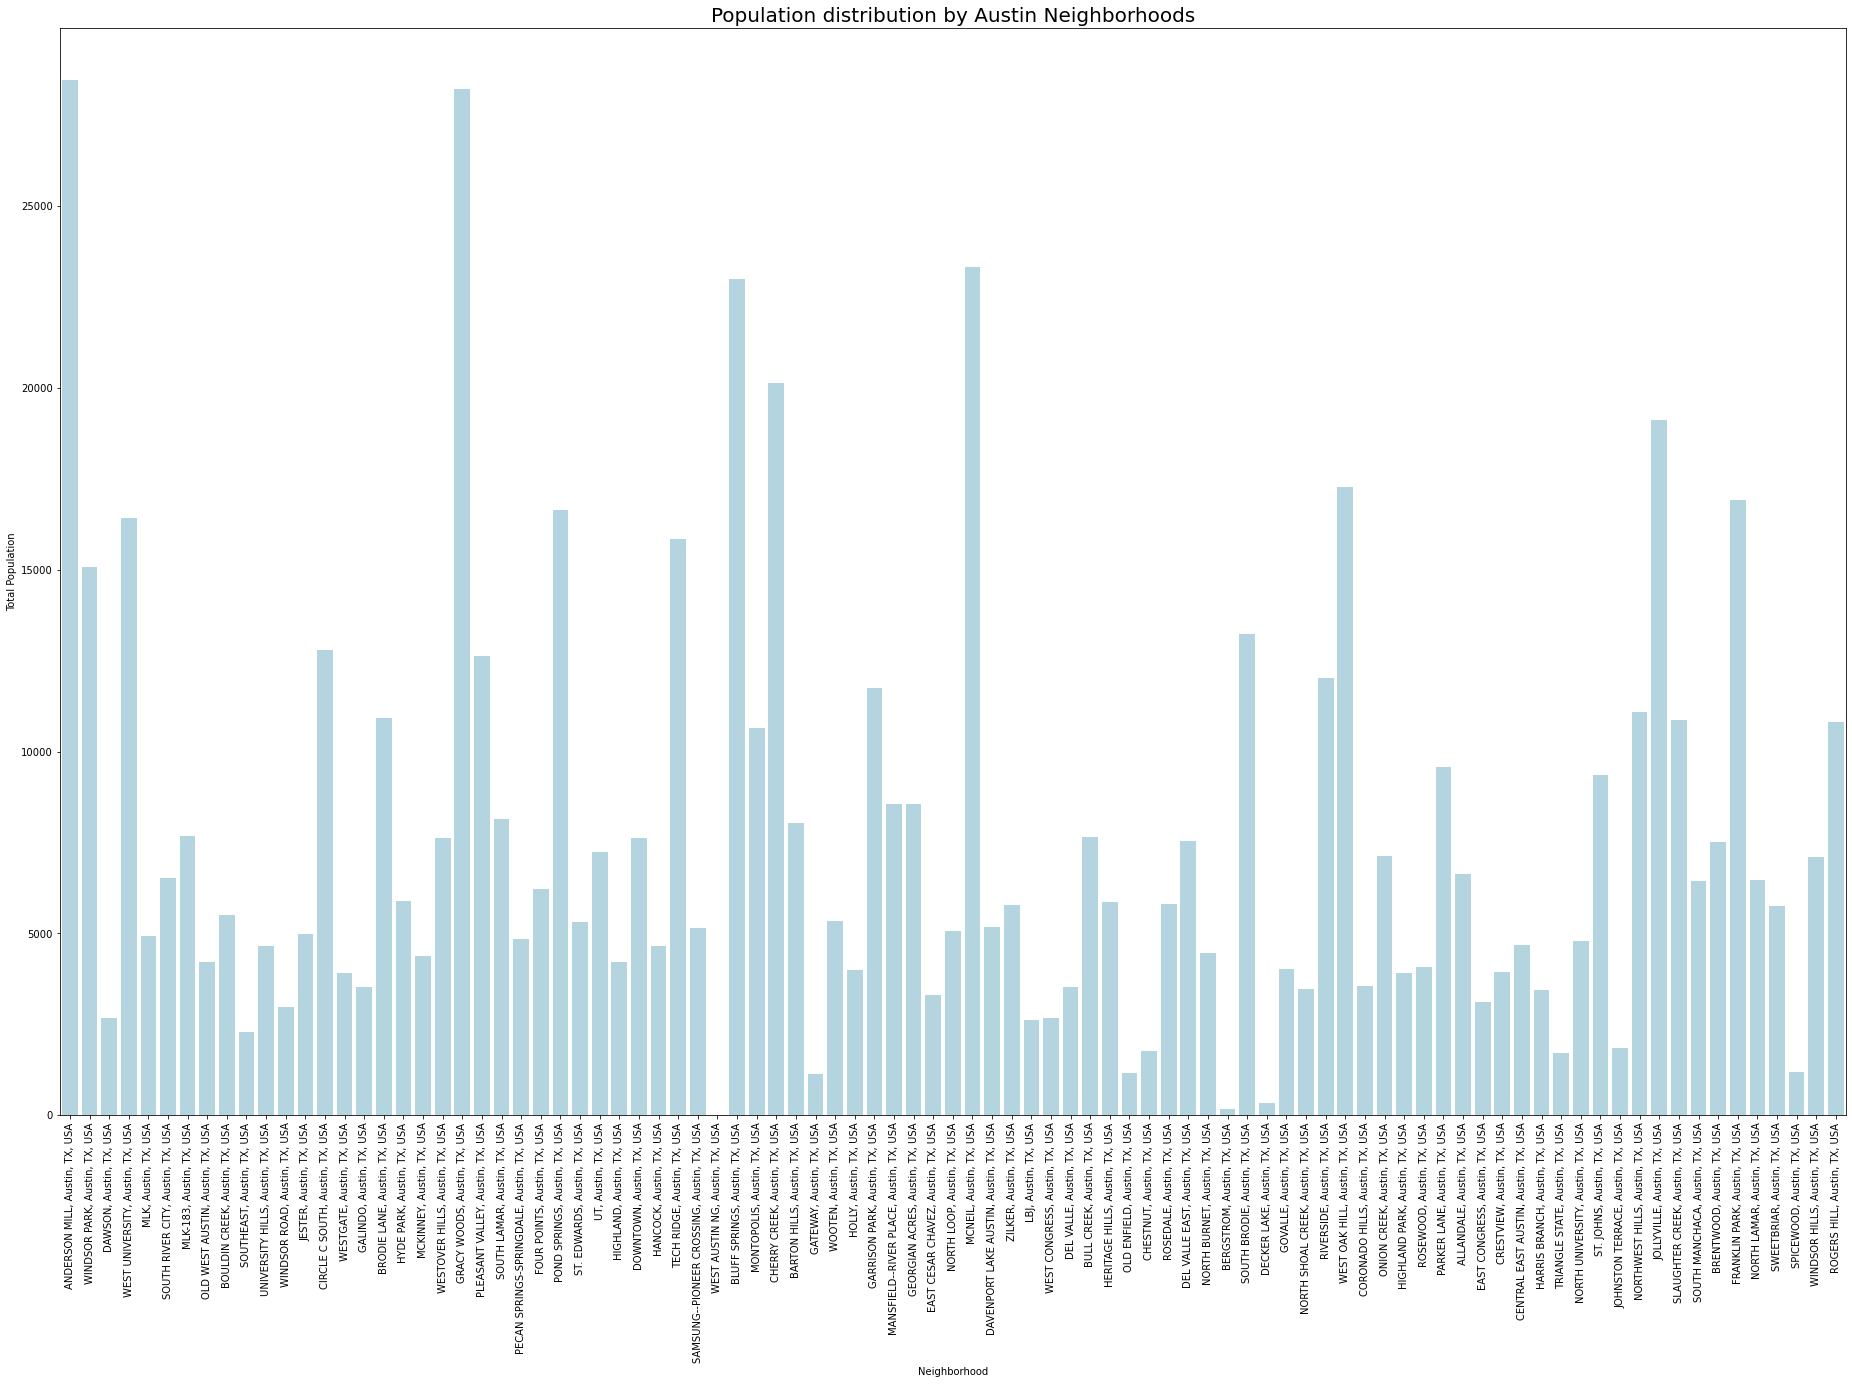

In [59]:
# Get total population across all neighborhoods
plt.rcParams['figure.figsize'] = (32, 20)
ax1 = sns.barplot(x=df_austin['Neighborhood'], y = df_austin['Total Population'], data=df_austin, color = 'lightblue').set_title("Population distribution by Austin Neighborhoods", fontsize = 20)
plt.xticks(rotation=90)

In [60]:
# Group Clusters to check the population distribution
df_clusters = df_austin.groupby('Clusters', axis=0).sum()
df_clusters.head()

latitude    longitude  Food Drinks   Gym  Recreation  Shopping  \
Clusters                                                                      
0         1090.669324 -3518.541448        611.0  36.0        29.0      24.0   
1          303.098364  -977.029441         26.0   3.0        13.0       4.0   
2          787.615394 -2541.242684        566.0  17.0        14.0       5.0   
3          575.278868 -1857.385022        226.0  17.0        19.0       9.0   

          Total Population  Age < 18  Age 18-24  Age 25-34  Age 35-44  \
Clusters                                                                
0                 281468.0  7.444674   4.989475   7.745715   5.044442   
1                  60374.0  2.775463   0.801630   1.815262   1.586757   
2                 185555.0  4.882056   3.649732   6.044134   3.952085   
3                 163094.0  3.813679   4.036880   3.605347   2.562512   

          Age 45-54  Age 55-64  Age 65 Plus  
Clusters                                     
0          4.111946   3.021336     2.642413  
1          1.277252   0.948613     0.795023  
2          3.043839   2.306794     2.121359  
3          2.190629   1.618710     1.172242

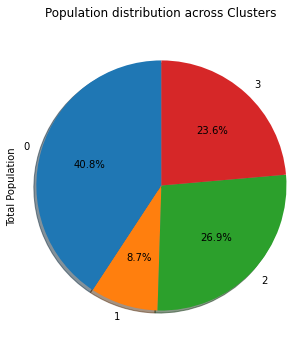

In [61]:
# Total Population distribution across clusters
df_clusters['Total Population'].plot(kind='pie',
                                figsize=(5, 6),
                                autopct='%1.1f%%', 
                                startangle=90,     
                                shadow=True,             
                                )

plt.title('Population distribution across Clusters')
plt.axis('equal') 

plt.show()

#### Cluster 0 has the highest total population

In [62]:
# Get mean of % of population distribution across different ag groups
df_population = df_austin.groupby('Clusters', axis=0).mean()
df_population = df_population.drop(['latitude', 'longitude', 'Food Drinks', 'Gym', 'Recreation', 'Shopping','Total Population'],1)
df_population.head()

Age < 18  Age 18-24  Age 25-34  Age 35-44  Age 45-54  Age 55-64  \
Clusters                                                                    
0         0.212705   0.142556   0.221306   0.144127   0.117484   0.086324   
1         0.277546   0.080163   0.181526   0.158676   0.127725   0.094861   
2         0.187771   0.140374   0.232467   0.152003   0.117071   0.088723   
3         0.200720   0.212467   0.189755   0.134869   0.115296   0.085195   

          Age 65 Plus  
Clusters               
0            0.075498  
1            0.079502  
2            0.081591  
3            0.061697

In [63]:
# Since the data is in %, we will multiple it by 100, to be able to read it better and compare
df_population = df_population.mul(100)
df_population.head()

Age < 18  Age 18-24  Age 25-34  Age 35-44  Age 45-54  Age 55-64  \
Clusters                                                                     
0         21.270496  14.255642  22.130614  14.412691  11.748418   8.632388   
1         27.754629   8.016301  18.152620  15.867568  12.772516   9.486134   
2         18.777137  14.037433  23.246670  15.200328  11.707074   8.872283   
3         20.071996  21.246739  18.975510  13.486905  11.529625   8.519528   

          Age 65 Plus  
Clusters               
0            7.549752  
1            7.950232  
2            8.159074  
3            6.169696

(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

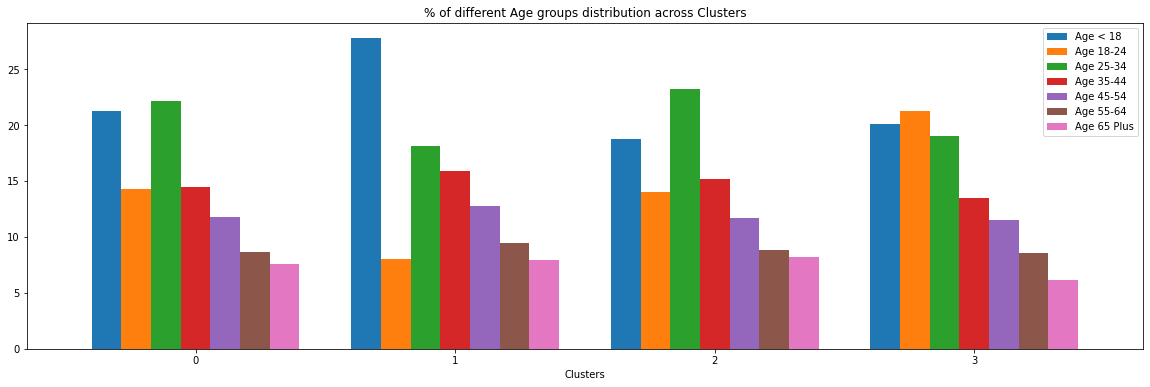

In [64]:
# Plot data showing % of different age groups across clusters
df_population.plot(kind="bar",figsize=(20,6),width = 0.8)
plt.title("% of different Age groups distribution across Clusters")
plt.xticks(rotation=0)

#### Cluster 0 had more uniform distribution among different age groups. More importantly, % of population in age groups <18, 18-24, 25-34 is good

### Analyzing Cluster 0 further

In [81]:
# Sort cluster 0 by descending value of all venue categories
cluster0.sort_values(['Food Drinks', 'Gym', 'Recreation', 'Shopping'], ascending=False)
cluster0

Clusters                        Neighborhood   latitude  longitude  \
72         0      EAST CONGRESS, Austin, TX, USA  30.210398 -97.766052   
86         0        NORTH LAMAR, Austin, TX, USA  30.369852 -97.687261   
83         0     SOUTH MANCHACA, Austin, TX, USA  30.219541 -97.783883   
62         0            GOVALLE, Austin, TX, USA  30.258676 -97.701216   
30         0            HANCOCK, Austin, TX, USA  30.295896 -97.724768   
44         0  EAST CESAR CHAVEZ, Austin, TX, USA  30.255896 -97.731707   
39         0             WOOTEN, Austin, TX, USA  30.361252 -97.722846   
37         0       BARTON HILLS, Austin, TX, USA  30.251571 -97.784106   
4          0                MLK, Austin, TX, USA  30.284035 -97.694001   
54         0        OLD ENFIELD, Austin, TX, USA  30.284864 -97.759106   
18         0           MCKINNEY, Austin, TX, USA  30.205876 -97.728015   
26         0        ST. EDWARDS, Austin, TX, USA  30.226948 -97.754610   
33         0     WEST AUSTIN NG, Austin, TX, USA  30.265587 -97.746996   
24         0        FOUR POINTS, Austin, TX, USA  30.403834 -97.853879   
48         0             ZILKER, Austin, TX, USA  30.254236 -97.769581   
29         0           DOWNTOWN, Austin, TX, USA  30.268054 -97.744764   
58         0       NORTH BURNET, Austin, TX, USA  30.380581 -97.723556   
80         0    NORTHWEST HILLS, Austin, TX, USA  30.355545 -97.768595   
88         0          SPICEWOOD, Austin, TX, USA  30.432946 -97.770378   
89         0      WINDSOR HILLS, Austin, TX, USA  30.362072 -97.679214   
46         0             MCNEIL, Austin, TX, USA  30.442015 -97.743840   
43         0     GEORGIAN ACRES, Austin, TX, USA  30.350096 -97.701756   
20         0        GRACY WOODS, Austin, TX, USA  30.402186 -97.700421   
36         0       CHERRY CREEK, Austin, TX, USA  30.197113 -97.824812   
9          0          SOUTHEAST, Austin, TX, USA  30.347189 -97.714563   
34         0      BLUFF SPRINGS, Austin, TX, USA  30.178720 -97.775929   
17         0          HYDE PARK, Austin, TX, USA  30.304412 -97.730448   
76         0     TRIANGLE STATE, Austin, TX, USA  30.314050 -97.734173   
14         0           WESTGATE, Austin, TX, USA  30.227962 -97.800881   
10         0   UNIVERSITY HILLS, Austin, TX, USA  30.317580 -97.673917   
5          0   SOUTH RIVER CITY, Austin, TX, USA  30.249443 -97.745558   
13         0     CIRCLE C SOUTH, Austin, TX, USA  30.249757 -97.748323   
51         0          DEL VALLE, Austin, TX, USA  30.211404 -97.652544   
31         0         TECH RIDGE, Austin, TX, USA  30.407091 -97.666131   
85         0      FRANKLIN PARK, Austin, TX, USA  30.196898 -97.748800   
66         0     CORONADO HILLS, Austin, TX, USA  30.325749 -97.684820   

    Food Drinks  Gym  Recreation  Shopping  Total Population  Age < 18  \
72           19    1           1         0            3104.0  0.175580   
86           19    1           1         0            6478.0  0.323402   
83           19    1           0         1            6453.0  0.174492   
62           19    1           0         0            4006.0  0.219171   
30           19    0           0         2            4662.0  0.068855   
44           19    0           0         0            3291.0  0.182619   
39           18    2           0         0            5339.0  0.248174   
37           18    1           0         0            8022.0  0.112441   
4            18    0           3         1            4917.0  0.293065   
54           18    0           3         1            1170.0  0.164103   
18           18    0           1         0            4369.0  0.319066   
26           18    0           1         0            5322.0  0.139421   
33           17    2           1         0               NaN       NaN   
24           17    2           0         1            6226.0  0.188564   
48           17    2           0         0            5779.0  0.137048   
29           17    1           1         1            7635.0  0.037197   
58     

Create a map to check all neighborhoods in Cluster 0

In [85]:
cluster0_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# instantiate a feature group for the neighborhoods in the dataframe
neighborhoods = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(cluster0['latitude'], cluster0['longitude']):
    neighborhoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(cluster0['latitude'])
longitudes = list(cluster0['longitude'])
labels = list(cluster0.Neighborhood)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(cluster0_map)    
    
# add incidents to map
cluster0_map.add_child(neighborhoods)

Creating a Heatmap for venue distribution in Cluster 0

In [86]:
# Since Food Drinks has maximum count, we can visualize how it is distributed in Cluster 0

cluster0_heatmap = folium.Map(location=[latitude, longitude], zoom_start=11)
# create heatmap layer
heatmap = HeatMap( list(zip(cluster0['latitude'], cluster0['longitude'], cluster0["Food Drinks"])),
                   min_opacity=0.2,
                   max_val=cluster0["Food Drinks"].max(),
                   radius=50, blur=50, 
                   max_zoom=1)
# add heatmap layer to base map
heatmap.add_to(cluster0_heatmap)
cluster0_heatmap

### Discussion

So where should Builders & Contractors build the next Apartment complexes? Clustering analysis revealed that Cluster 0 had the maximum number of venues across all categories. Demographic information supports this which was inferred as part of further analysis done using demographic and cluster information. It was observed that Cluster 0 had the highest total population and the percent distribution among the youth population also was significant. With all this visualization, it was inferred that Cluster 0 is what would be recommended to Builders & Contractors for setting up new Apartment complexes in the neighborhoods in it as the current trend supports it and it has all the things that could appeal to youth population. 
Some of the neighborhoods in Cluster 0 than can be picked are Downtown, Cherry Creek, Georgian Acres, East Congress. Although, all neighborhoods in the cluster are promising.


### Conlusion

In this project, neighborhood data was collected and combined with location and venue data to get characteristics on which neighborhoods can be grouped in clusters. Demographic information containing population distribution across neighborhood was added to analysis, all to support and answer the business problem - where should construction of next Apartment complex should happen in Austin, TX? It was inferred that several neighborhoods like Downtown, Georgian Acres to name a few are promising locations where construction could happen as it will appeal the young crowd for the various amenities they offer and ease of accessibility of restaurants, parks, gyms, etc. Current population trend supports this inference and this project can be used to predict the likely and preferred neighborhoods. 

This study can be extended, and several factors can be added to analysis like safety of neighborhoods, proximity to offices, public transport and many more which will help in coming up with better recommendations. This will help Builders & Contractors meet the needs of their future residents and attract more of them. It will also benefit residents as they would get desirable and comfortable accommodation suiting their requirements.
